In [1]:
# ---------------- Importing used libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

In [2]:
# ---------------------- Initial details & save path
save_path = 'C:\\Users\\michael.moore\\OneDrive - RSSB\\Python scripts'
date = datetime.today().strftime('%Y-%m-%d')
name = '2024-DWG-Analysis' + '-' + date

In [3]:
# ----------------- parameters
year = '2024/25'
startperiod = 202201
endperiod = 202412
N = 38
fyearpoints = [6.5, 19.5, 31.5]
bigticks = [-0.5, 12.5, 25.5, N - 0.5]
bigticks2 = [-0.5, 12.5, 25.5, N - 0.5]
xlimitend = N - 0.5
ylimitend = 0.06

In [4]:
# Load CSV
csv_path = 'C:\\Users\\Micha\\OneDrive\\Projects\\depot_incident_analysis\\csv\\fwi_per_incident.csv'

# Read CSV into DataFrame
smis_df = pd.read_csv(csv_path)

In [5]:
# ------ Finding out structure of dataframe
smis_df.info()
smis_df.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6101 entries, 0 to 6100
Data columns (total 8 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   smis_reference          6101 non-null   object 
 1   event_date              6101 non-null   object 
 2   period                  6101 non-null   int64  
 3   place                   6059 non-null   object 
 4   report_title            6101 non-null   object 
 5   sub_event               6091 non-null   object 
 6   personal_accident_type  5778 non-null   object 
 7   fwi_2013                6101 non-null   float64
dtypes: float64(1), int64(1), object(6)
memory usage: 381.4+ KB


smis_reference              0
event_date                  0
period                      0
place                      42
report_title                0
sub_event                  10
personal_accident_type    323
fwi_2013                    0
dtype: int64

In [6]:
# --- Looking at dataset sample

smis_df.head(5)

,smis_reference,event_date,period,place,report_title,sub_event,personal_accident_type,fwi_2013
0,SMIS309149,2018-04-02 06:00:00.000,201801,Manchester Longsight MDU,Slip trip or fall,slip trip or fall,"Slip, trip, fall",0.001
1,SMIS238120,2018-04-03 11:00:00.000,201801,Tyne Yard,"Person interacting with animal, object, vehic...",person interaction,"Interaction with plant, machine, equip or tool",0.001
2,SMIS239138,2018-04-03 22:30:00.000,201801,Singlewell IMD,"Person interacting with animal, object, vehic...",person interaction,"Interaction with plant, machine, equip or tool",0.001
3,SMIS238148,2018-04-04 00:00:00.000,201801,Etches Park LMD (Derby),"Person interacting with animal, object, vehic...",person interaction,"Interaction with plant, machine, equip or tool",0.001
4,SMIS309200,2018-04-04 14:30:00.000,201801,Carlisle St Nicholas Bridge MDU,Slip trip or fall,slip trip or fall,"Slip, trip, fall",0.001


In [7]:
# ------------------------- Combining columns into 'event_type_combined' for analysis
smis_df['event_type_combined'] = smis_df.apply(
    lambda row: row['personal_accident_type'] if row['personal_accident_type'] and not pd.isna(row['personal_accident_type']) 
    else row['sub_event'] if row['sub_event'] and not pd.isna(row['sub_event']) 
    else "Other", 
    axis=1
)

In [8]:
# - Event category mapping
event_category_mapping = {
    'Slip, trip, fall': 'Slip, Trip, Fall',
    'Interaction with plant, machine, equip or tool': 'Interaction with Plant, Machine, Equip or Tool',
    'Hazardous susbstance': 'Hazardous susbstance',
    'Awkward body movement': 'Awkward Body Movement',
    'Interaction with train': 'Interaction with Train',
    'Assault or abuse': 'Other',
    'Electric shock': 'Other',
    'fire or explosion': 'Other',
    'Hazardous condition': 'Other',
    'Incorrect usage of level crossing': 'Other',
    'incorrect usage of level crossing; person interaction': 'Other',
    'Interaction with an animal': 'Other',
    'Interaction with person': 'Other',
    'Interaction with railway infrastructure': 'Other',
    'Interaction with road vehicle': 'Other',
    'machine plant equipment or tool failure': 'Other',
    'other event resulting in injury fatality': 'Other',
    'other event resulting in injury fatality; train derailment': 'Other',
    'train colliding with another train': 'Other',
    'person interaction': 'Other',
    'non rail vehicle collision': 'Other',
    'train fault': 'Other',
    'train derailment': 'Other',
    'railway operating incident': 'Other',
    'railway operating incident; object road vehicle animal on near line': 'Other',
    'Other': 'Other',
    'vandalism; other event resulting in injury fatality': 'Other',
    'person in a prohibited area': 'Other'
}


# Apply the mapping to DataFrame
smis_df['event_category'] = smis_df['event_type_combined'].map(event_category_mapping)

In [9]:
# ------------------------ Grouping of events by counts and sums

# Grouping events by period, category and fwi
smis_counts1 = smis_df.groupby(['period', 'event_category'])['fwi_2013'].count()

# Group by period and category, then sum fwi:
fwi_sums = smis_df.groupby(['period', 'event_category'])['fwi_2013'].sum()

# Calculate per-incident fwi_2013 (sum divided by count)
smis_counts2 = (fwi_sums / smis_counts1).unstack('event_category').fillna(0)

In [10]:
# --- Add a column for total injury incidents
smis_counts2['TotalFWI'] = smis_counts2.sum(axis=1)

# ------------ Creating annual moving average
smis_counts2_ama = smis_counts2.rolling(window=13).mean()

smis_counts2 = smis_counts2_ama

In [11]:
# ----- make dataframe for results 
# range of fiscal years in graph
Nyears = 3 #number of years in graph
ymax = int(year[:4])
ymin = int(ymax)-Nyears+1
for i in range(Nyears+1):
    p1 = np.arange(1,14)
    y1 = int(ymax)-Nyears+i
    y2 = y1+1
    data = pd.DataFrame({'Periods':p1.astype(str)})
    data['Index'] = str(y1)+data['Periods'].str.zfill(2)
    data['Index'] = data['Index'].astype(int)
    data['Periods'] = 'P'+data['Periods']
    data['Fiscal year'] = str(y1)+'/'+str(y2)
    if i==0:
        data1 = data
    else:
        data1 = pd.concat([data1, data],sort=True)
        
data1 = data1.set_index('Index')

smis_data2 = data1.join(smis_counts2) 
smis_data2 = smis_data2.fillna(0)

In [12]:
# --------------------- Setting start and end period cuts
smis_data2 = smis_data2[smis_data2.index>=startperiod] #only want periods after this
#all_data1[all_data1.index>202003] = float('nan')
smis_data2 = smis_data2[smis_data2.index<=endperiod] #only want periods before this

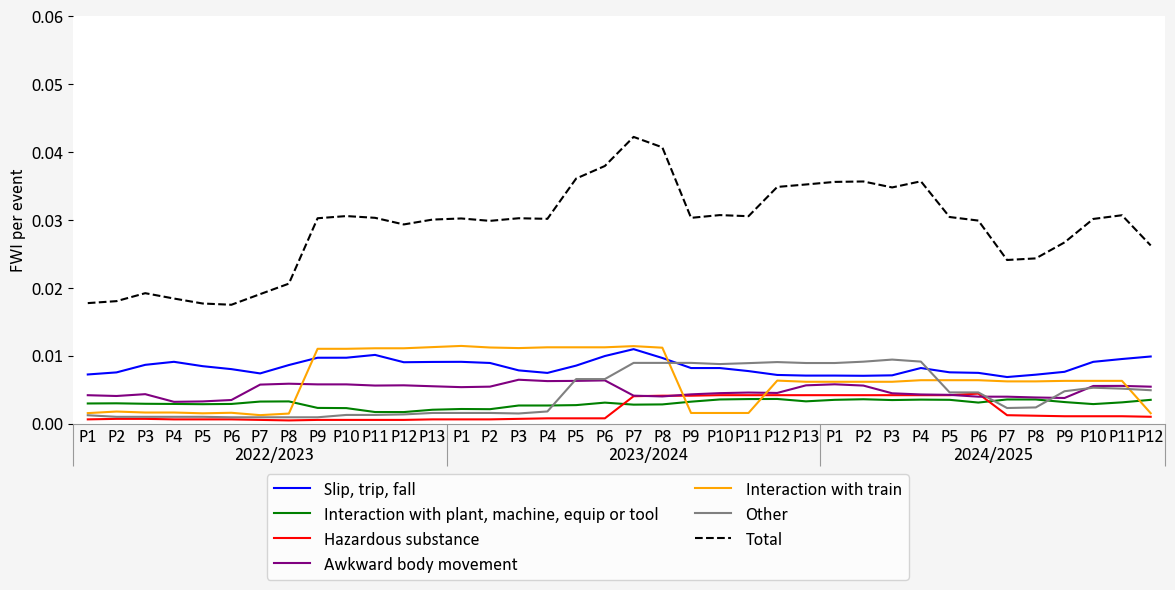

In [13]:
# --------------------------------- Drawing chart

# set font parameters
plt.rcParams['svg.fonttype'] = 'none'
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = 'Calibri'
plt.rcParams['font.size'] = 13.0

# parameters for graphs
fig = plt.figure(figsize=(13, 6))
width = 0.5
#N = Nyears*13
ind = np.arange(0,N,1)
bordercolour = '0.6'

#graphtitle = 'FWI per incident' #graph title
 
# x tick mark locations for all graphs
# making ticks and labels for big graph
ticks1 = np.arange(0,N,1) #set tick intervals
ticklabels1 = smis_data2['Periods'].iloc[ticks1] #get labels at correct intervals
ticklabels1 = ticklabels1.tolist()
fyears = '\n' + smis_data2['Fiscal year'].dropna().unique() #fiscal years (\n makes it go one line below)
ticklabels1 = ticklabels1 + fyears.tolist()
ticks1 = ticks1.tolist() + fyearpoints


ax1 = fig.add_subplot(1,1,1)
# set labels
ax1.set(ylabel='FWI per event')
# set xticks
ax1.set_xlim(-0.5,xlimitend)
ax1.set_ylim(0,ylimitend)
ax1.set_xticks(ticks1, minor=True)
ax1.set_xticklabels(ticklabels1, minor=True)
ax1.set_xticks(bigticks)
ax1.set_xticklabels([])
ax1.tick_params(axis='x',which='minor',length=0)
ax1.tick_params(axis='x',which='major',length=30,color=bordercolour)



#ax1.yaxis.grid(which="major", color=bordercolour, linestyle='-', linewidth=1, zorder=0) #add gridlines
ax1.plot(ind, np.array(smis_data2['Slip, Trip, Fall']), color='blue', zorder=3, label='Slip, trip, fall')
ax1.plot(ind, np.array(smis_data2['Interaction with Plant, Machine, Equip or Tool']), color='green', zorder=3, label='Interaction with plant, machine, equip or tool')
ax1.plot(ind, np.array(smis_data2['Hazardous susbstance']), color='red', zorder=3, label='Hazardous substance')
ax1.plot(ind, np.array(smis_data2['Awkward Body Movement']), color='purple', zorder=3, label='Awkward body movement')
ax1.plot(ind, np.array(smis_data2['Interaction with Train']), color='orange', zorder=3, label='Interaction with train')
ax1.plot(ind, np.array(smis_data2['Other']), color='grey', zorder=3, label='Other')

# Plot the total FWI events AMA as a dashed line:
ax1.plot(ind, np.array(smis_data2['TotalFWI']), color='black', linestyle='--', zorder=3, label='Total')  # Dashed line

ax1.spines['left'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
ax1.spines['bottom'].set_color(bordercolour)

#fig.suptitle(graphtitle, y=1.01)  # Adjust the y-value to move the title if needed

# Adjust layout
fig.tight_layout(pad=4.0)  # Ensure there is enough space between elements

# Move legend outside of the plot to the right
fig.legend(loc='upper center', bbox_to_anchor=(0.5, 0.12), ncol=2)  # 2 columns  # Legend outside of plot

fig.patch.set_facecolor('whitesmoke')
plt.show()
